In [1]:
import decoupler as dc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
msigdb = dc.get_resource('MSigDB')
msigdb.head()

/tscc/nfs/home/pjaganna1/anaconda3/envs/decoupler/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP


In [3]:
msigdb = msigdb[msigdb['collection']=='go_biological_process'] # filter for GO biological processes

In [4]:
# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

In [5]:
# Rename
msigdb.loc[:, 'geneset'] = [name.split('GOBP_')[1] for name in msigdb['geneset']]

In [10]:
# Load in genes associated with the isoform clusters
gene_tables = {}
for key in range(5):
    gene_tables[key + 1] = pd.read_csv(f"/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/231_data/model/gene_five_sig_group_cluster_{key+1}.txt", header=None)

In [11]:
go_pvals = {}
for i in gene_tables:
    top_genes = gene_tables[i].copy()
    top_genes = top_genes.rename(columns={0: 'gene_name'})
    top_genes = top_genes.set_index('gene_name')
    top_genes['group'] = 'NT.vs.COCL2'
    
    # Run ora
    enr_pvals = dc.get_ora_df(
        df=top_genes,
        net=msigdb,
        source='geneset',
        target='genesymbol'
    )
    
    #enr_pvals = enr_pvals[enr_pvals['FDR p-value']<=0.05]
    enr_pvals['-log10 FDR p-value'] = -np.log10(enr_pvals['FDR p-value'])
    go_pvals[i] = enr_pvals


In [13]:
full_set_onlysig = pd.DataFrame()
for i in go_pvals:
    tmp = go_pvals[i][['Term', '-log10 FDR p-value', 'Odds ratio']]
    tmp['Cluster'] = str(i)
    tmp = tmp[tmp['-log10 FDR p-value'] >= -np.log10(0.05)]
    tmp =  tmp.sort_values(by='-log10 FDR p-value', ascending=False).head(10)
    full_set_onlysig = pd.concat([full_set_onlysig, tmp])

/tmp/ipykernel_766665/4063016652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Cluster'] = str(i)
/tmp/ipykernel_766665/4063016652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Cluster'] = str(i)
/tmp/ipykernel_766665/4063016652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [14]:
import os

<Axes: xlabel='Cluster', ylabel='Term'>

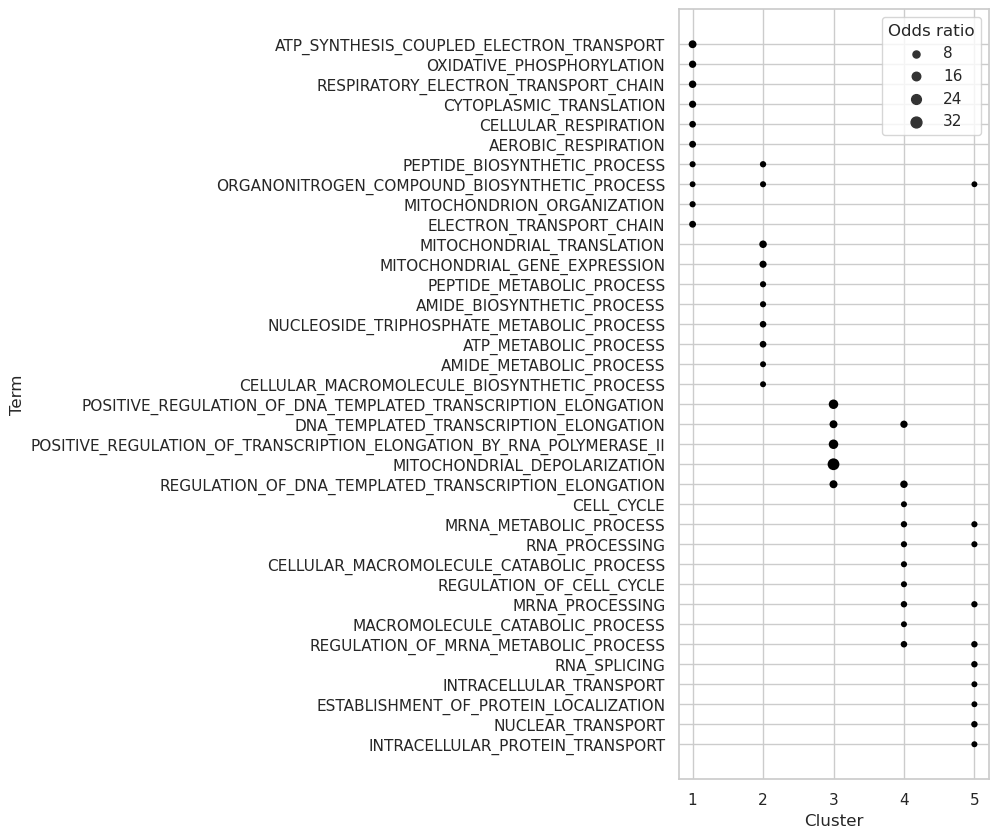

In [15]:
sns.set(rc={'figure.figsize':(4,10)})
sns.set_style('whitegrid')
#sns.scatterplot(data=full_set_onlysig, x='Cluster', y='Term', hue='-log10 FDR p-value', size='Odds ratio', linewidth=0, color='dark')
sns.scatterplot(data=full_set_onlysig, x='Cluster', y='Term', size='Odds ratio', linewidth=0, color='Black')

In [25]:
#full_set_onlysig.to_csv('./GO_transcript_clustering_on_editsC_five_groups_sig_and_RPKM_jan2024.txt', sep='\t', index=False)